In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
df = pd.read_csv('RadiationPattern.csv')
df.head()
# Rename your columns directly using the .csv file

,Angle,Power
0,0,-36.10
1,5,-38.61
2,10,-43.15
3,15,-47.63
4,20,-53.55


In [2]:
# Data preprocessing
df = df[df['Power']!=0.0]
df.loc[df['Angle'] > 70, 'Angle'] -= 360
df = df.sort_values(by='Angle')
df['Power(Linear)'] = 10**(df['Power']/10)
# df['Power_(Linear)'] = Power0*10**(df['Power_13']/10)

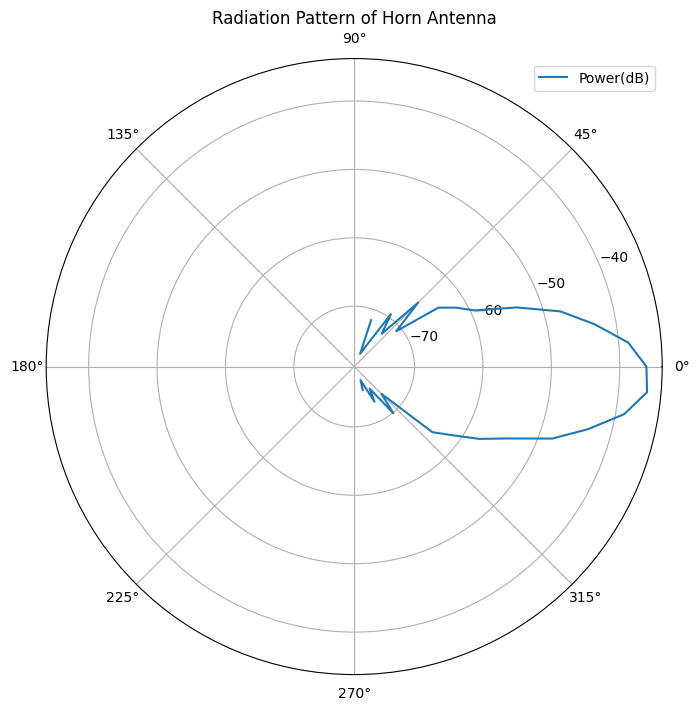

In [3]:
angle = df['Angle']*np.pi/180
power = df['Power']
plt.figure(figsize=(10,8))
plt.polar(angle, power, label='Power(dB)')
plt.title('Radiation Pattern of Horn Antenna')
plt.legend()
plt.savefig('HornAntenna.png');

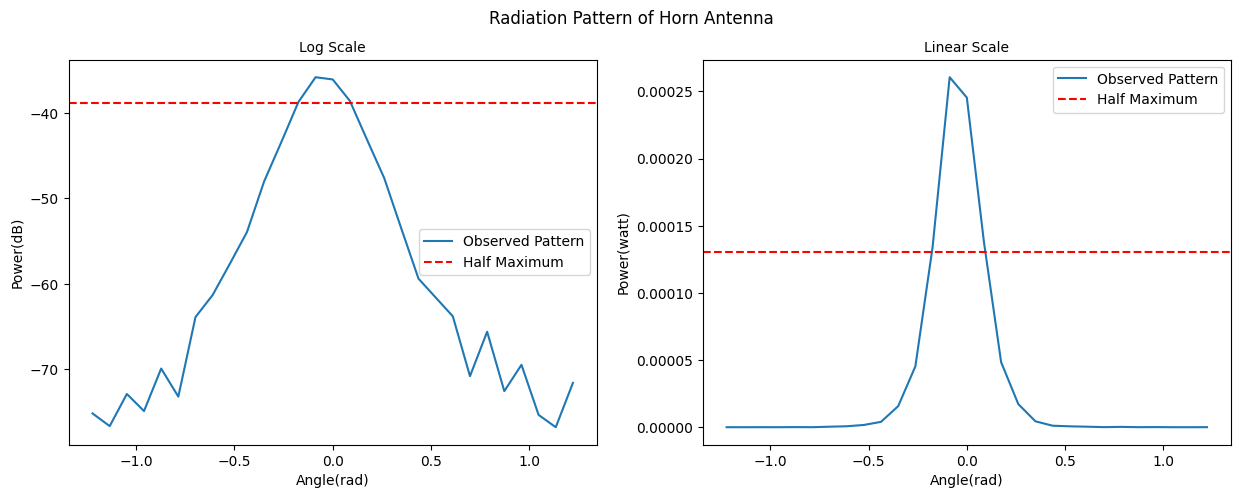

Half of the Maximum Power:-38.84


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Radiation Pattern of Horn Antenna')

axes[0].plot(angle, power, label='Observed Pattern')
axes[0].axhline(max(power)-3, c='r', linestyle='--', label='Half Maximum')
axes[0].set_title('Log Scale', size=10)
axes[0].set_xlabel('Angle(rad)')
axes[0].set_ylabel('Power(dB)')
axes[0].legend()

axes[1].plot(angle,df['Power(Linear)'], label='Observed Pattern')
axes[1].axhline(max(df['Power(Linear)'])/2,c='r', linestyle='--', label='Half Maximum')
axes[1].set_title('Linear Scale', size=10)
axes[1].set_xlabel('Angle(rad)')
axes[1].set_ylabel('Power(watt)')
axes[1].legend()

plt.savefig('LogLinear.png')
plt.show()

print(f"Half of the Maximum Power:{max(power)-3}")

Angular Width aka Half Power Beamwidth:0.20466566367128947 rad


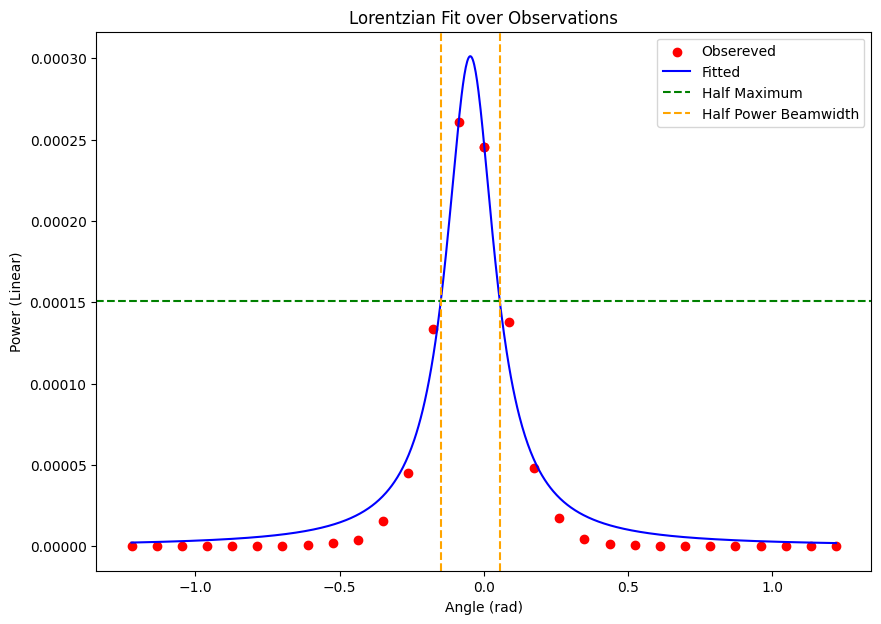

In [5]:
plt.figure(figsize=(10,7))
plt.scatter(angle,df['Power(Linear)'], color='red', label='Obsereved')
def lorentzian(x, x0, gamma, A):
    return A * (1/np.pi) * (gamma / ((x - x0)**2 + gamma**2))
params, covt = curve_fit(lorentzian, angle, df['Power(Linear)'])
pred_angle = np.linspace(min(angle),max(angle), 1000)
pred_power = lorentzian(pred_angle, params[0], params[1], params[2])
plt.plot(pred_angle, pred_power, color='blue',label='Fitted')
plt.axhline(max(pred_power)/2, color='green', linestyle='--', label='Half Maximum')
eps = 0.0
plt.axvline(params[0]-params[1]-eps, color='orange', linestyle='--', label='Half Power Beamwidth')
plt.axvline( params[0]+params[1]+eps, color='orange', linestyle='--')
plt.xlabel('Angle (rad)')
plt.ylabel('Power (Linear)')
plt.title('Lorentzian Fit over Observations')
plt.legend()
plt.savefig('lorentzianfit.png')

print(f"Angular Width aka Half Power Beamwidth:{2*(params[1]+eps)} rad")

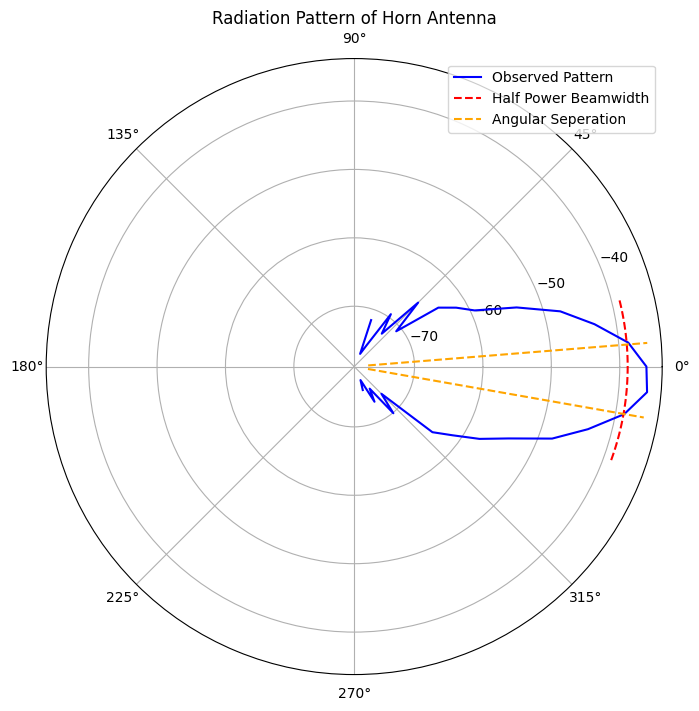

In [6]:
eps=0.2
angular_seperation = np.linspace(params[0]-params[1]-eps, params[0]+params[1]+eps, 100)
half_power = np.ones_like(angular_seperation)*((max(power)-3))

eps = 0.025
power_array = np.linspace(min(power),max(power),100)
up_angle_array = np.ones_like(power_array)*(params[0]-params[1]-eps)
down_angle_array = np.ones_like(power_array)*(params[0]+params[1]+eps)

plt.figure(figsize=(10,8))
plt.polar(angle, power, color='blue', label='Observed Pattern')
plt.polar(angular_seperation,half_power, color='red', linestyle='--',label='Half Power Beamwidth')
plt.polar(up_angle_array,power_array, color='orange',linestyle = '--', label='Angular Seperation')
plt.plot(down_angle_array,power_array, color='orange', linestyle = '--')
plt.title("Radiation Pattern of Horn Antenna")
plt.legend()
plt.savefig('HornAntennaWidth.png');

#### Due to the reciprocity property of the Horn Antenna the data we obtained isnt the singal but convolution of signal produced by the virtue of transmitter and reciever horn antennas, keeping this in my we have to deconvolved the signal. for that we will do following thing.

data = signal * signal<br>
FT(data) = FT(signal * signal)<br>
FT(data) = FT(signal)FT(signal) = FT(signal)^2<br>
signal = IFT(sqrt(FT(data)))<br>

since data has -ve sign<br>
for taking the sqrt -1 * data * -1<br>
sqrt(-data) possible and sqrt(-1) = i which multiplied later<br>

In [7]:
linear_power_fft = np.fft.fft(df['Power(Linear)'])
lpf_shift = np.fft.fftshift(linear_power_fft)

signal = np.fft.ifft(np.sqrt(np.abs(lpf_shift)))
signal_shift = np.fft.fftshift(signal)
convolved_linear_power = np.abs(signal_shift)

Angular Width aka Half Power Beamwidth:0.15247391654035233 rad at Frequency 16 Hz


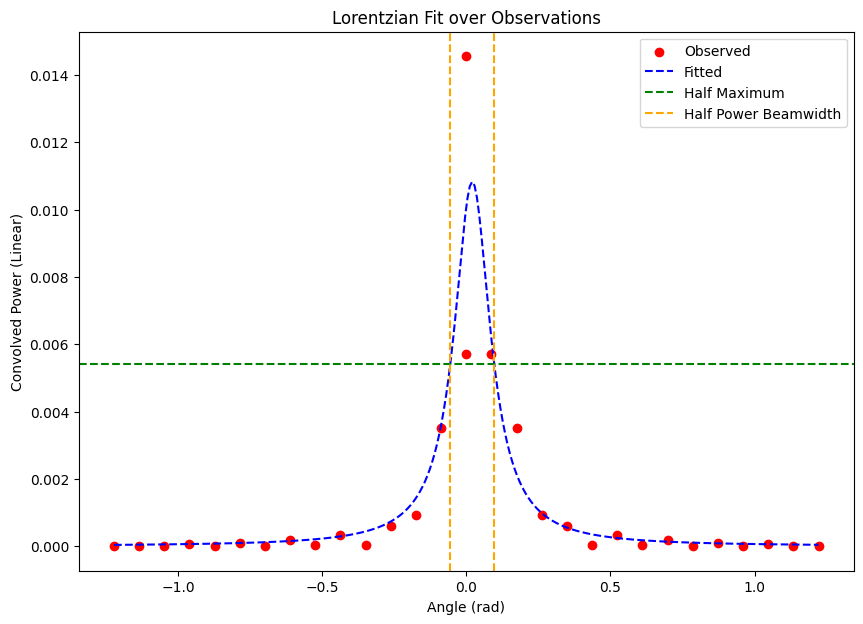

In [8]:
ic = [0.0, 0.25, max(convolved_linear_power)]
plt.figure(figsize=(10,7))
params, covt = curve_fit(lorentzian, angle, convolved_linear_power, p0=ic)
plt.scatter(angle, convolved_linear_power, color='red', label='Observed')
pred_angle = np.linspace(min(angle), max(angle), 300)
pred_power = lorentzian(pred_angle, params[0], params[1], params[2])
plt.plot(pred_angle, pred_power, color='blue', linestyle='--', label='Fitted')

plt.axhline(max(pred_power)/2, color='green', linestyle='--', label='Half Maximum')
eps = 0.0
plt.axvline(params[0]-params[1]-eps, color='orange', linestyle='--', label='Half Power Beamwidth')
plt.axvline( params[0]+params[1]+eps, color='orange', linestyle='--')
plt.xlabel('Angle (rad)')
plt.ylabel('Convolved Power (Linear)')
plt.title('Lorentzian Fit over Observations')
plt.legend()
plt.savefig('convolvedlorentzianfit.png')
print(f"Angular Width aka Half Power Beamwidth:{2*(params[1]+eps)} rad at Frequency 16 Hz")

### Writing a function to repea this same procedure for readings taken at different frequencies

In [9]:
def convolutor(df_power_db, angle_degree, frequency):
    angle = np.radians(angle_degree)
    df_power_linear = 10**(df_power_db/10)
    linear_power_fft = np.fft.fft(df_power_linear)
    lpf_shift = np.fft.fftshift(linear_power_fft)

    signal = np.fft.ifft(np.sqrt(np.abs(lpf_shift)))
    signal_shift = np.fft.fftshift(signal)
    convolved_linear_power = np.abs(signal_shift)

    ic = [0.0, 0.25, max(convolved_linear_power)]
    plt.figure(figsize=(10,7))
    params, covt = curve_fit(lorentzian, angle, convolved_linear_power, p0=ic)
    plt.scatter(angle, convolved_linear_power, color='red', label='Observed')
    pred_angle = np.linspace(min(angle), max(angle), 300)
    pred_power = lorentzian(pred_angle, params[0], params[1], params[2])
    plt.plot(pred_angle, pred_power, color='blue', linestyle='--', label='Fitted')

    plt.axhline(max(pred_power)/2, color='green', linestyle='--', label='Half Maximum')
    eps = 0.0
    plt.axvline(params[0]-params[1]-eps, color='orange', linestyle='--', label='Half Power Beamwidth')
    plt.axvline( params[0]+params[1]+eps, color='orange', linestyle='--')
    plt.xlabel('Angle (rad)')
    plt.ylabel('Convolved Power (Linear)')
    plt.title(f'Lorentzian Fit over Observations for Frequency {frequency} Hz')
    plt.legend()
    plt.savefig(f'convolvedlorentzianfit{frequency}.png')
    plt.show()
    print(f"Angular Width aka Half Power Beamwidth:{2*(params[1]+eps)} rad = {np.degrees(2*(params[1]+eps))} degrees at Frequency {frequency} GHz")

    pred_power_db = np.log10(10*pred_power)
    fig, axs = plt.subplots(1, 2, subplot_kw=dict(polar=True), figsize=(10,7))
    fig.suptitle(f'Radiation Pattern Of Horn Antenna at Frequency {frequency} GHz', size=18)
    axs[1].set_title('Convolved Signal (Lorentzian Fit)')
    axs[1].plot(pred_angle, pred_power_db)
    # Plot on the second subplot
    axs[0].plot(angle, df_power_db)
    axs[0].set_title('Data Obtained')
    plt.savefig(f'RadiationPatternTwoPlots{frequency}')
    plt.show()

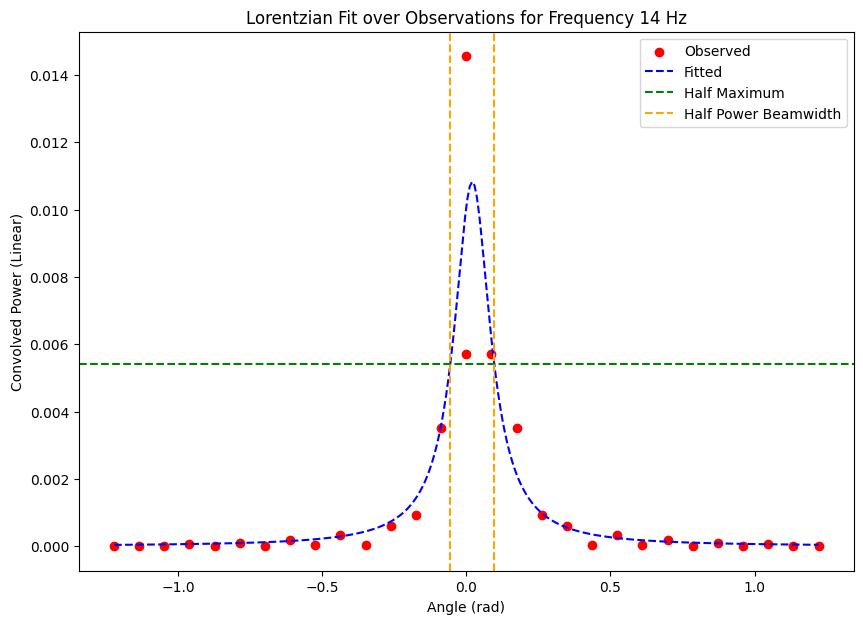

Angular Width aka Half Power Beamwidth:0.15247391654035233 rad = 8.736111903592143 degrees at Frequency 14 GHz


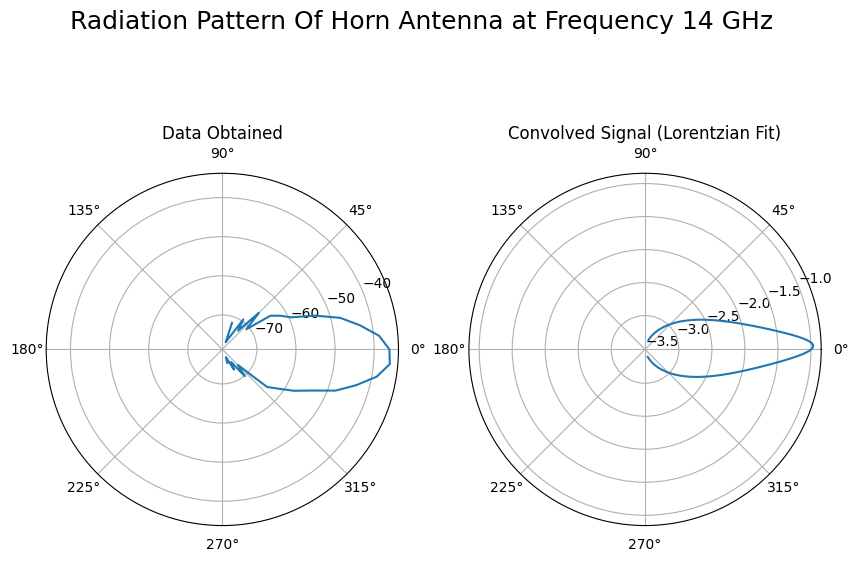

In [10]:
convolutor(df['Power'], df['Angle'], 14)

In [11]:
add_df = pd.read_csv('HornFinalReadings.csv')
add_df.head()

,Angle,Power_16,Power_13,Power_17
0,-90,-70.50,-75.30,-63.01
1,-85,-68.20,-75.30,-64.66
2,-80,-67.10,-72.41,-64.06
3,-75,-68.59,-68.21,-61.01
4,-70,-65.57,-68.21,-65.19


c:\Users\win 10\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


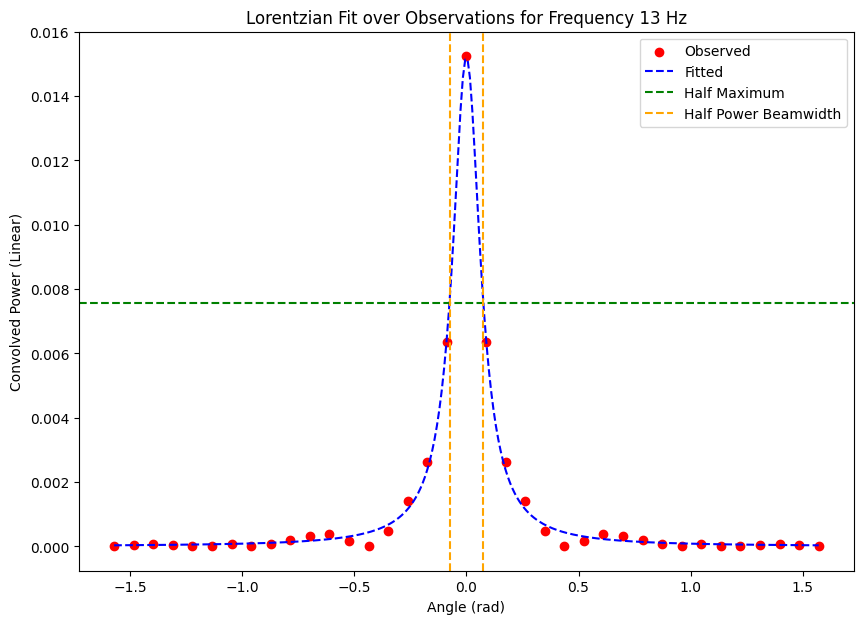

Angular Width aka Half Power Beamwidth:0.1504293069056794 rad = 8.6189644007736 degrees at Frequency 13 GHz


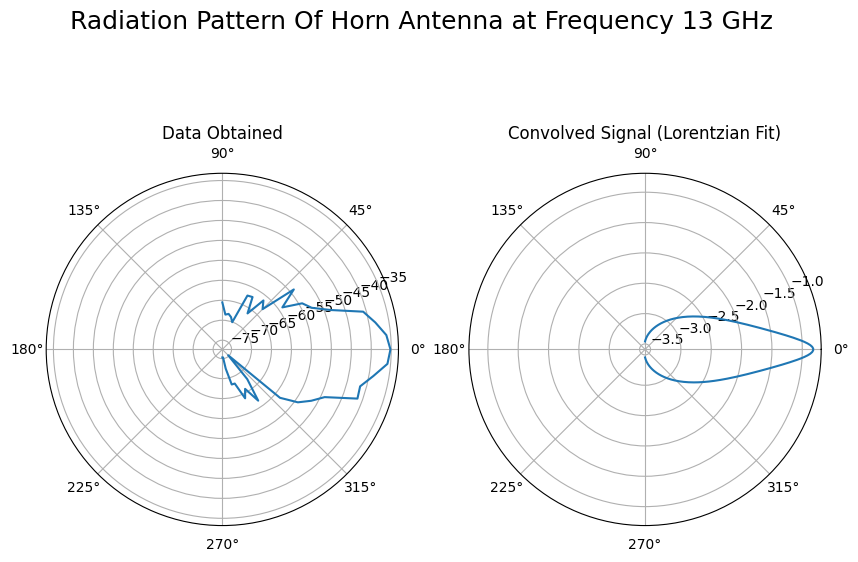

In [12]:
convolutor(add_df['Power_13'], add_df['Angle'], 13)

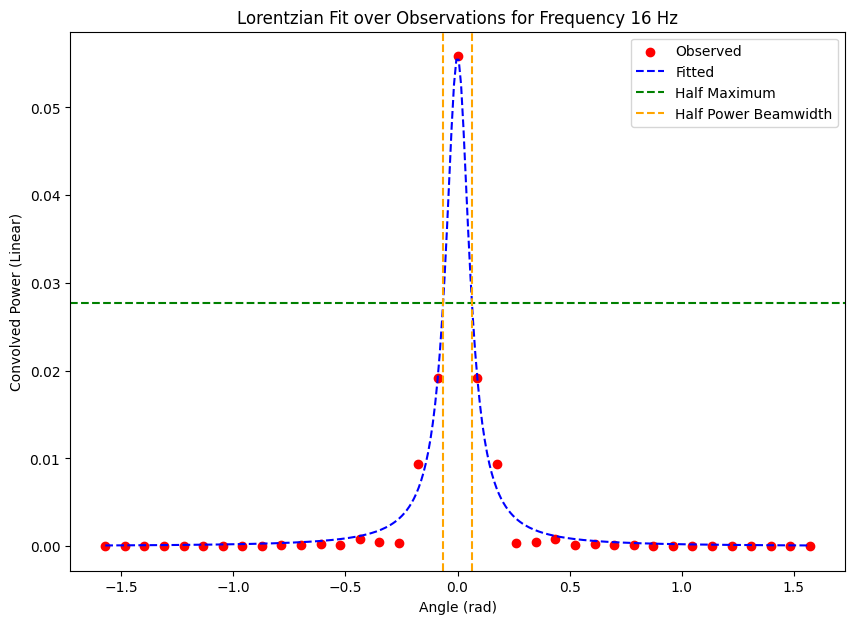

Angular Width aka Half Power Beamwidth:0.1276455219437367 rad = 7.31354968112065 degrees at Frequency 16 GHz


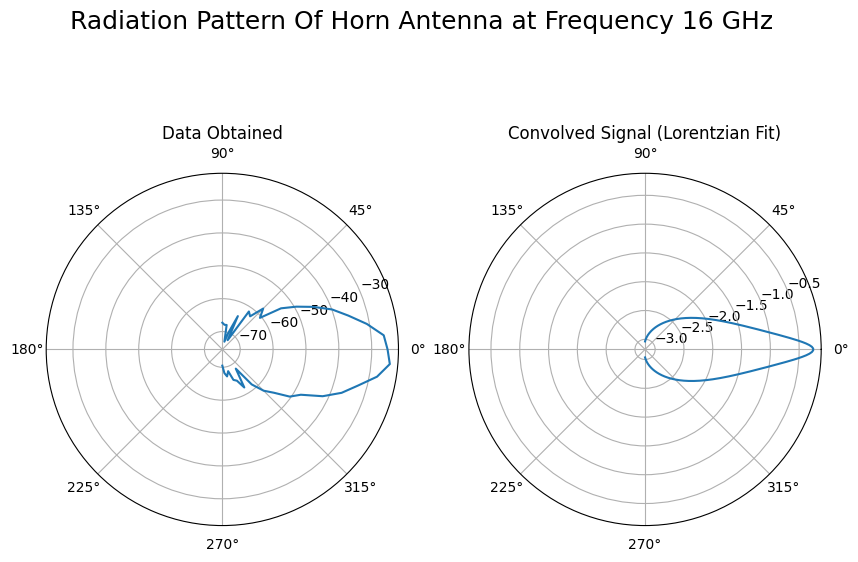

In [13]:
convolutor(add_df['Power_16'], add_df['Angle'], 16)

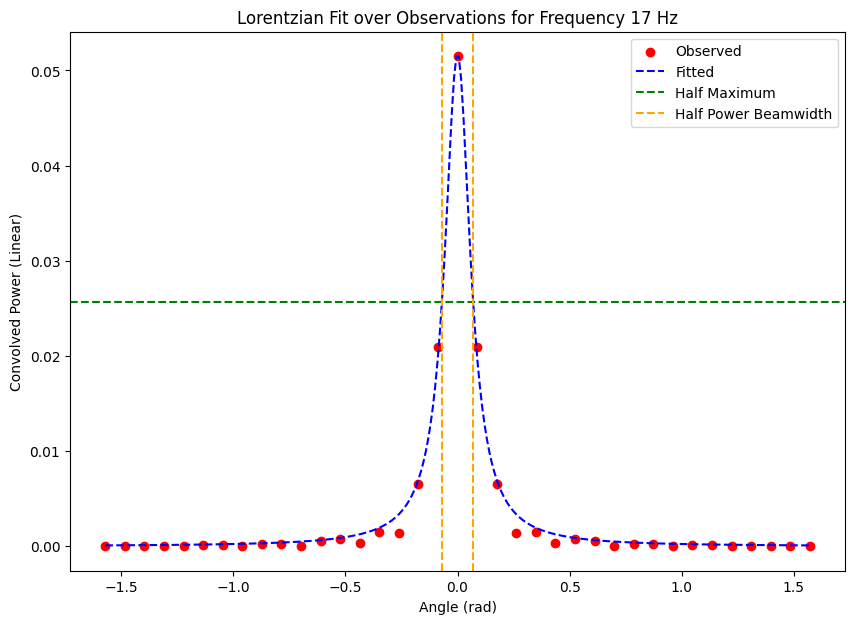

Angular Width aka Half Power Beamwidth:0.13821820455715486 rad = 7.919319773000855 degrees at Frequency 17 GHz


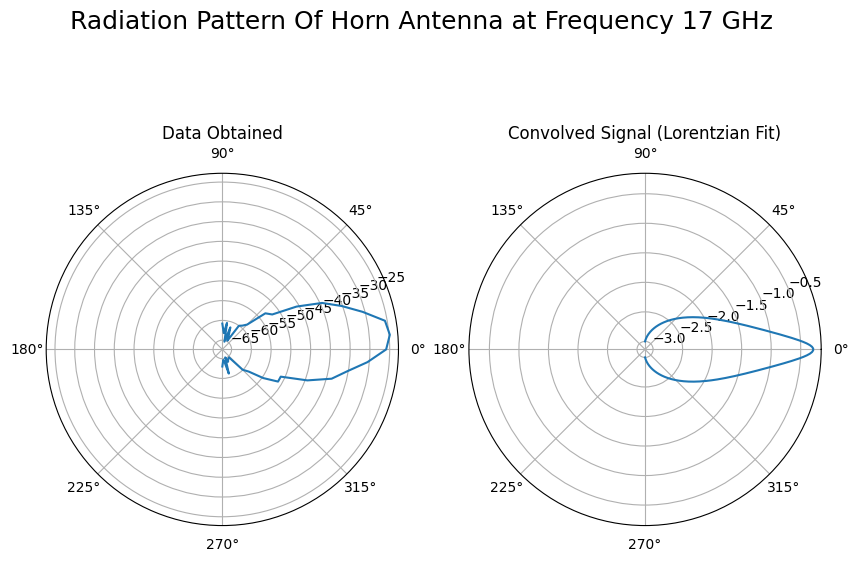

In [14]:
convolutor(add_df['Power_17'], add_df['Angle'], 17)

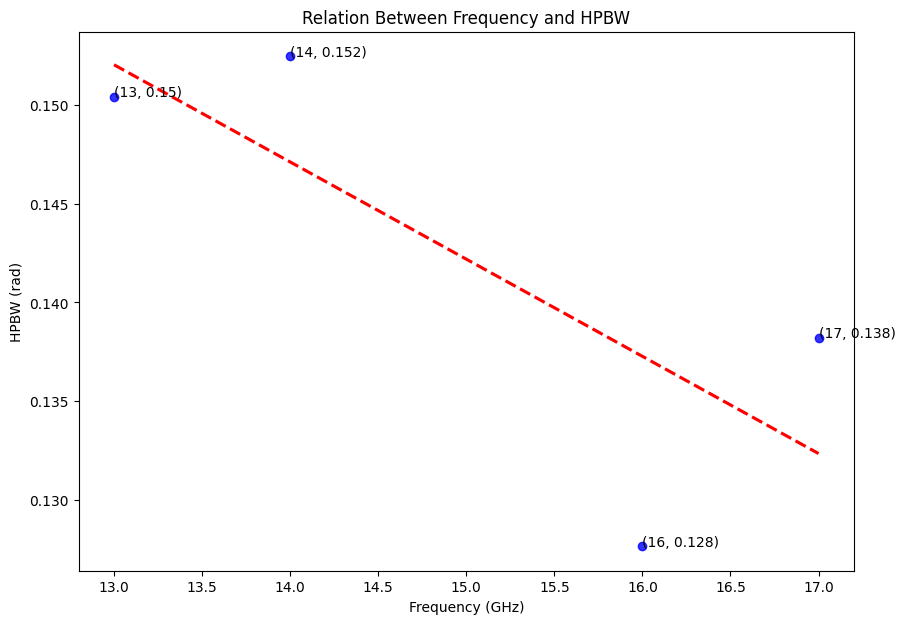

In [15]:
HPBW = [0.1504293069056794,0.15247391654035233, 0.1276455219437367, 0.13821820455715486]
Freq_GHz = [13, 14, 16, 17]
import seaborn as sns
plt.figure(figsize=(10,7))
sns.regplot(x=Freq_GHz, y=HPBW, ci=0, color='blue', line_kws={'color':'red', 'linestyle':'--'})
for i in range(len(HPBW)):
    plt.annotate(str((Freq_GHz[i], round(HPBW[i],3))),(Freq_GHz[i],HPBW[i]))
plt.title("Relation Between Frequency and HPBW")
plt.xlabel('Frequency (GHz)')
plt.ylabel('HPBW (rad)')
plt.savefig('RelBtwnFreqHPBW.png');